In [1]:
from aqchem.chemistry import Solute, elements
from aqchem.equilibria import Equilibrium, EqSystem, charge_balance, atom_balance
from IPython.display import Latex, display
import periodictable
%matplotlib inline

In [2]:
def show(s): display(Latex('$'+s+'$'))

In [3]:
substances = Hp, OHm, NH4p, NH3, H2O, Cupp, CuNH31pp, CuNH32pp, CuNH33pp, CuNH34pp, CuNH35pp, Cu2OH2pp, CuOH3m, CuOH4mm, CuOH2 = [#, CuOHp, CuOH2, =
    Solute(n, latex_name=l, formula=periodictable.formula(n)) for n, l in [
        ('H{+}', 'H^+'), ('HO{-}', 'OH^-'), ('NH3 + H{+}', 'NH_4^+'),
        ('NH3', 'NH_3'), ('H2O', 'H_2O'), ('Cu{2+}', 'Cu^{2+}'), ('Cu{2+}NH3', 'Cu(NH_3)^{2+}'),
        ('Cu{2+}(NH3)2', 'Cu(NH_3)_2^{2+}'), ('Cu{2+}(NH3)3', 'Cu(NH_3)_3^{2+}'),
        ('Cu{2+}(NH3)4', 'Cu(NH_3)_4^{2+}'), ('Cu{2+}(NH3)5', 'Cu(NH_3)_5^{2+}'), 
        ('2Cu{2+} + 2HO{-}', 'Cu_2(OH)_2^{2+}'),
        ('Cu{2+} + 3HO{-}', 'Cu(OH)_3^-'), ('Cu{2+} + 4HO{-}', 'Cu(OH)_4^{2-}'),
        ('Cu{2+} + 2HO{-}', 'Cu(OH_2)(s)'),
    ]]
CuOH2.solid = True

In [4]:
show(', '.join([s.latex_name for s in substances])) # + r'(\mathrm{%s})' % (str(s.formula.atoms) + ', ' + str(s.charge))

<IPython.core.display.Latex object>

In [5]:
init_conc = {Hp: 1e-7, OHm: 1e-7, NH4p: 0, NH3: 1.0, Cupp: 1e-2, 
            CuNH31pp: 0, CuNH32pp: 0, CuNH33pp: 0, CuNH34pp: 0, CuNH35pp: 0,
            H2O: 55.5, Cu2OH2pp: 0, CuOH2: 0, CuOH3m: 0, CuOH4mm: 0}

In [6]:
H2O_c = init_conc[H2O]
w_autop = Equilibrium({H2O: 1}, {Hp: 1, OHm: 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({NH4p: 1}, {Hp: 1, NH3: 1}, 10**-9.26)
CuOH2_s = Equilibrium({CuOH2: 1}, {Cupp: 1, OHm: 2}, 10**-18.8)
CuOH_B3 = Equilibrium({CuOH2: 1, OHm: 1}, {CuOH3m: 1}, 10**-3.6)
CuOH_B4 = Equilibrium({CuOH2: 1, OHm: 2}, {CuOH4mm: 1}, 10**-2.7)
Cu2OH2 = Equilibrium({Cupp: 2, H2O: 2}, {Cu2OH2pp: 1, Hp: 2}, 10**4.3 * H2O_c**2)
CuNH3_B1 = Equilibrium({CuNH31pp: 1}, {Cupp: 1, NH3: 1}, 10**4.3)
CuNH3_B2 = Equilibrium({CuNH32pp: 1}, {Cupp: 1, NH3: 2}, 10**7.9)
CuNH3_B3 = Equilibrium({CuNH33pp: 1}, {Cupp: 1, NH3: 3}, 10**10.8)
CuNH3_B4 = Equilibrium({CuNH34pp: 1}, {Cupp: 1, NH3: 4}, 10**13.0)
CuNH3_B5 = Equilibrium({CuNH35pp: 1}, {Cupp: 1, NH3: 5}, 10**12.4)
equilibria = w_autop, NH4p_pr, CuNH3_B1, CuNH3_B2, CuNH3_B3, CuNH3_B4, CuNH3_B5, Cu2OH2, CuOH_B3, CuOH_B4, CuOH2_s
skip_subs, skip_eq = (4, 4) # (0, 0), (1, 1), (3, 3), (4, 4), (11, 9)
simpl_subs = substances[:-skip_subs]
simpl_eq = equilibria[:-skip_eq]
simpl_c0 = {k: init_conc[k] for k in simpl_subs}

In [7]:
show(', '.join([s.latex_name for s in simpl_subs]))
show('~')
from math import log10
for eq in simpl_eq:
    ltx = eq.latex()
    show(ltx + '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~lgK = {0:12.5g}'.format(log10(eq.params)))
{k.name: v for k, v in simpl_c0.items()}

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

{'Cu{2+}': 0.01,
 'Cu{2+}(NH3)2': 0,
 'Cu{2+}(NH3)3': 0,
 'Cu{2+}(NH3)4': 0,
 'Cu{2+}(NH3)5': 0,
 'Cu{2+}NH3': 0,
 'H2O': 55.5,
 'HO{-}': 1e-07,
 'H{+}': 1e-07,
 'NH3': 1.0,
 'NH3 + H{+}': 0}

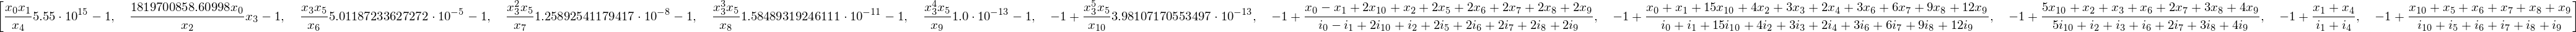

In [8]:
eqsys = EqSystem(simpl_eq, simpl_subs)
import sympy as sp
sp.init_printing()
x, i = sp.symarray('x', eqsys.ns), sp.symarray('i', eqsys.ns)
f, piv, cbs = eqsys.f(x, i, norm=True)
#subs = [(_, sp.exp(_)) for _ in x]
#[_.subs(subs).powsimp() for _ in f]
f

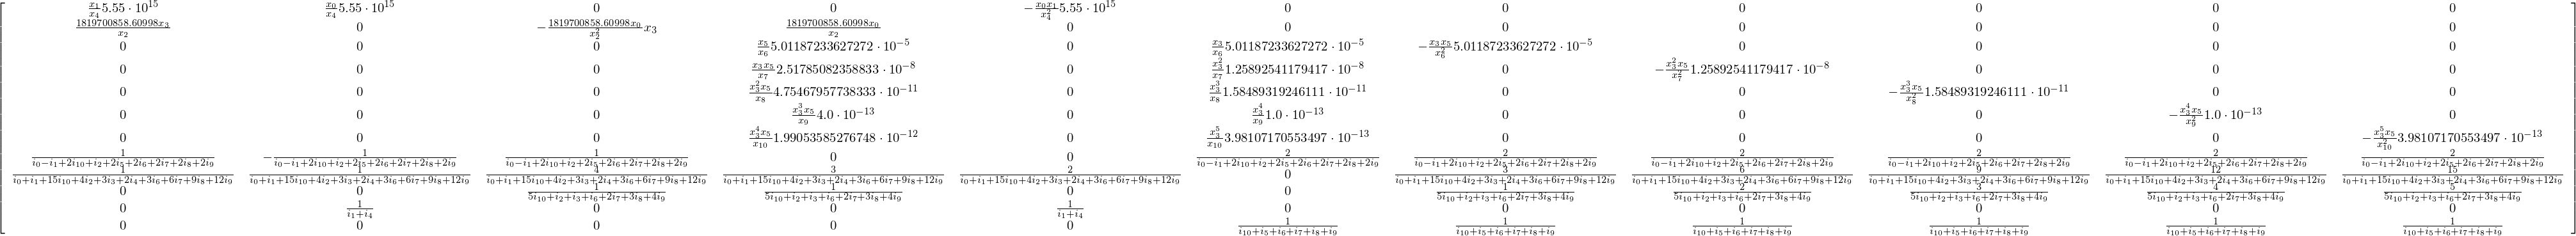

In [9]:
sp.Matrix(1, len(f), lambda _, q: f[q]).jacobian(x)

In [10]:
len(f), eqsys.ns

In [11]:
eqsys.root(simpl_c0, delta=1e-6, method='lm')
#eqsys.root({H2O: 55.5, Hp: 1e-10, OHm: 1e-3, NH3: 1.0, NH4p: 1e-3}, delta=1e-6, method='lm')

aqchem/equilibria.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  tot *= conc**nr


(array([  9.83288339e-09,   5.90444021e-07,   1.58061115e-06,
          1.00985112e+00,   5.55000015e+01,   1.03217731e-02,
          5.24281724e-07,   4.59413913e-08,   4.57929663e-08,
          4.12088912e-08,   4.46633114e-08]),
   status: 1
   cov_x: array([[  3.86993804e-05,   3.85888387e-05,   6.22082713e-03,
          5.90788930e-08,  -3.85888387e-05,   4.41582661e-04,
          2.31391569e-08,   2.02762615e-09,   2.02236116e-09,
          2.02236387e-09,   2.02236657e-09],
       [  2.09008128e-05,   1.99715972e+00,   3.35975482e-03,
          1.53118779e-03,  -9.97159718e-01,   1.14121845e+01,
          5.98004298e-04,   5.24016135e-05,   5.22655462e-05,
          5.22656163e-05,   5.22656865e-05],
       [  6.22082708e-03,   6.20304952e-03,   9.99982220e-01,
          9.50660182e-06,  -6.20304952e-03,   7.09699393e-02,
          3.71886107e-06,   3.25874447e-07,   3.25028273e-07,
          3.25028708e-07,   3.25029144e-07],
       [ -1.63960795e-05,  -2.65201412e-03,  -2.6356

False

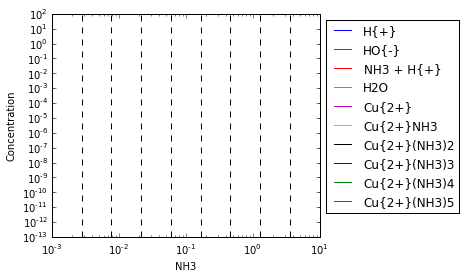

In [27]:
import numpy as np
_1, _2, success = eqsys.plot(simpl_c0, NH3, np.logspace(-3, 1, 10), method='lm', norm=True)
all(success)

/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__i

True

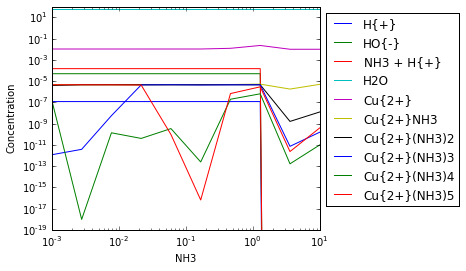

In [28]:
import numpy as np
x, inits_out, success = eqsys.plot(simpl_c0, NH3, np.logspace(-3, 1, 10), delta=1e-4, method='lm',
                                   carry=False, logC=True, pres1st=True, presw=100) #, init_iter=50)#, pres1st=True, norm=True, scaling=1)
all(success)

aqchem/equilibria.py:25: RuntimeWarning: divide by zero encountered in reciprocal
  tot *= conc**nr
aqchem/equilibria.py:25: RuntimeWarning: invalid value encountered in multiply
  tot *= conc**nr


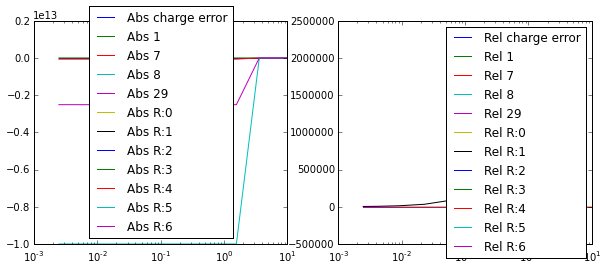

In [14]:
eqsys.plot_errors(x, inits_out, NH3)

In [15]:
for eq in equilibria:
    show(eq.latex())

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [16]:
reaction_system = EqSystem(equilibria, substances)

In [17]:
import sympy as sp
#sp.init_printing()
y = sp.symarray('y', len(substances))
s = sp.symbols('s')

ys = []
class LatexSymbol(sp.Symbol):
    def _print_latex(self):
        return self.name
  
for sbs in reaction_system.substances:
    ys.append(LatexSymbol('[' + sbs.latex_name + ']'))
    print(ys[-1].name)
ys

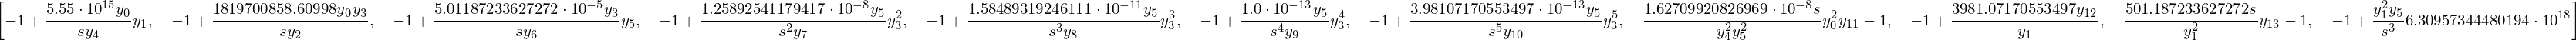

In [29]:
qk = reaction_system.qk(y, scaling=s, norm=True)
qk

In [19]:
charge_balance(substances, y)

In [20]:
atom_balance(substances, y, 1)

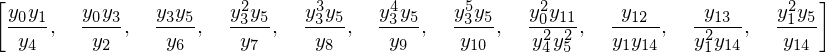

In [21]:
reaction_system.equilibrium_quotients(y)

In [22]:
chg_vec = reaction_system.charge_balance_vector()
atm_vecs, atm_nrs = reaction_system.atom_balance_vectors()
import numpy as np
arr = np.array(atm_vecs)
arr.shape, atm_nrs, arr, chg_vec

((4, 15),
 [1, 7, 8, 29],
 array([[ 1,  1,  4,  3,  2,  0,  3,  6,  9, 12, 15,  2,  3,  4,  2],
        [ 0,  0,  1,  1,  0,  0,  1,  2,  3,  4,  5,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  2,  3,  4,  2],
        [ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1]]),
 [1, -1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, -1, -2, 0])

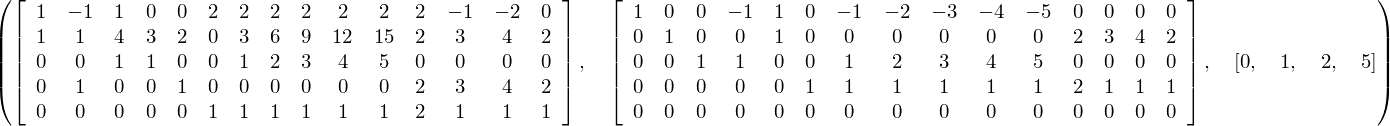

In [23]:
import sympy
M = sympy.Matrix([chg_vec] + atm_vecs)
rref, pivot = M.rref()
M, rref, pivot

In [24]:
rref, pivot = reaction_system.rref()
atm_nrs = reaction_system.atom_balance_vectors()[1]
[0] + atm_nrs
#reaction_system.independent_atoms_from_pivot(pivot)

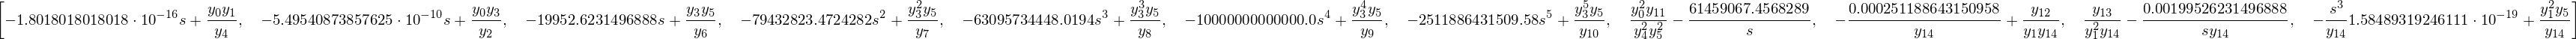

In [25]:
qk

In [26]:
c0arr = np.array([init_conc[k] for k in reaction_system.substances])
scaling = 1.0
logC = False
f, j = reaction_system.num_cb_factory(c0arr*scaling, True, scaling=scaling, logC=logC)
c0arr

ValueError: too many values to unpack

In [ ]:
x0 = c0arr+1e-17
f(np.log(x0) if logC else x0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
jmat = j(np.log(x0) if logC else x0)
plt.imshow(jmat, cmap='binary', interpolation='None')
jmat[:7, :4].tolist()

In [ ]:
len(substances)

In [ ]:
from scipy.optimize import root
x0 = [1]*len(substances)
root(f, x0, jac=j)

In [ ]:
reaction_system.root(init_conc, scaling=scaling, logC=logC, delta=1e-15)

In [ ]:
i = sp.symarray('i', len(y))
print(i)
reaction_system.f(y, i, scaling=s, reduced=True)

In [ ]:
f_elim, j_elim, elim, elm_cbs = reaction_system.num_cb_factory(c0arr*scaling, True, scaling=scaling, logC=logC, reduced=True)
print(elim)

In [ ]:
c0arr_elim = np.array([x for idx, x in enumerate(c0arr) if idx not in elim]) + 1e-13
x0elim = np.log(c0arr_elim) if logC else c0arr_elim
f_elim(x0elim)

In [ ]:
jmat = j_elim(x0elim)
plt.imshow(jmat, cmap='binary', interpolation='None')
x0elim

In [ ]:
jmat

In [ ]:
reaction_system.root(init_conc, scaling=1e8, init_iter=100)